# Upper confidence bound Algorithm (Multi Armed Bandit)

(Naveen Mysore, navimn1991@gmail.com)

## Abstract

Multi armed bandit algorithms are a class of powerful algorithms that run the modern world. They are used every where from running clinical trails with RCT, Massive AB Testing to recommending movies on Netflix. The problem is still open for an optimal or near optimal solution and studies are still being conducted to find a scalable solution [reference](https://www.nature.com/articles/s41598-021-83726-8). On the other hand some empirical studies done by evolutionary biologists seem to show that plants and slime molds can solve this problem in a tractable time [reference](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2016.0030) which questions the fundamentals of intelligence theory. These algorithms are so powerful that, studies are now being conducted in political sciences to see how are they affecting modern democracy [reference](https://www.tandfonline.com/doi/abs/10.1080/08838151.2020.1757365) and polarization of society. If you use any of the internet products like Netflix, TikTok, E commerce platforms or any social media platform then you might have noticed that they recommend products or media contents that so well tuned for your tastes [reference](https://www.youtube.com/watch?v=kY-BCNHd_dM&t=589s&ab_channel=DataCouncil). These systems have modelled your behavior so well that they do a great job at grabbing your attention. In this article, I will conduct an empirical study showing how these algorithms work so that we can study their impacts on real world. We will first define the problem and explore solutions like epsilon greedy algorithms and upper confidence bound algorithms and lay ground work for contextual bandit algorithms.


## Introduction

[Multi armed bandit algorithms](https://en.wikipedia.org/wiki/Multi-armed_bandit) derive their origins from probability theory and machine learning. The core of the problem is the exploration - exploitation dilemma that an autonomous agent suffers. An autonomous agent is something that is capable of making it's own decision based on perceived information. For example, You and I are autonomous agents since we receive information from our environment and take decisions or actions based on some internal state. At every instance of time an autonomous agent has to make a decision whether to explore something new or to exploit something which is familiar to it. Based on the decision chosen by the agent, the environment rewards the agent with some positive or negative feedback. 

The problem is often explained using an analogy of a casino slot machine. Typically a casino slot machine has an arm lever which upon pulling rewards you with some coins, now imagine a slot machine with $k$ arms or lever and at a time you have to pull one lever. You are faced repeatedly with a choice among $k$ different actions or options. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. The objective here is to maximize the expected total reward over some time period. In a typical setting, the content you see on your phone are the choices and the algorithms are modeling your behavior based on the feedback you give them. In this case the you are the environment and the apps like Netflix and tiktok are autonomous agents trying to model you. 



## Epsilon Greedy and UCB

Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly. The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring. Unlike epsilon greedy, rather than performing exploration by simply selecting an arbitrary action, chosen with a probability that remains constant, the UCB algorithm changes its exploration-exploitation balance as it gathers more knowledge of the environment.

## Experiment setup

The goal of this experiment is to compare multi arm bandit problem with epsilon $\epsilon$ greedy approach and upper confidence bound algorithm. In this experiment we will setup $k=10$ arm bandit and compare four epsilon approaches (0.0, 0.01, 0.1, 0.5) followed by upper confidence bound method. We will be running lots of iterations and episodes. Computing averages for these rewards are both space and computationally expensive and hence we will be using running averages. This implies we just need to store two variables in memory ( previous mean and current reward ). Here is the derivation.

Let $m_n$ be mean or average value of rewards at $n^{th}$ time step. Let $n$ be the total number of iterations. Let $R_i$ be reward at $i^{th}$ time step.

Then

\begin{equation*}
m_n = \frac{\sum_{i=1}^n R_i}{n}
\end{equation*}

\begin{equation*}
m_n = \frac{(\sum_{i=1}^{n-1}R_i)+R_n}{n}
\end{equation*}

\begin{equation*}
m_n = \frac{Rn}{n}+\frac{\sum_{i=1}^{n-1}R_{n-1}}{n}
\end{equation*}

The sum of $n-1$ rewards $\sum_{i=1}^{n-1}R_{n-1}$ can also be written as $m_{n-1}$*${n-1}$. Using this the previous equation can be written as

\begin{equation*}
m_n = \frac{Rn}{n} + \frac{(n-1)m_{n-1}}{n}
\end{equation*}

Rearranging terms we get
\begin{equation*}
m_n = m_{n-1}+\frac{R_{n}-m_{n-1}}{n}
\end{equation*}

Which means, just by keep track of current reward $R_{i}$ and running mean $m_{n-1}$ we can update the new mean $m_{n}$ by above equation.

\begin{equation*}
m_n  \Leftarrow m_{n-1}+\frac{R_{n}-m_{n-1}}{n}
\end{equation*}

Programatically we can express this as function 

In [24]:
running_average = lambda m_n_1, r_i, n: m_n_1 + ((r_i - m_n_1) / n)

Let us import all the packages we will be needing for this experiment.

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns

## Environment reward setup

We can imagine a system with $k$ arms and for each arm the machine gives us a numerical reward from a sample distribution of mean $mu$ and standard deviation $sd$. We can the model this distrubtion with the code below.

In [26]:
class RewardDistribution:
    def __init__(self, k=10):
        self.k = k
        self.mu = 0
        self.sigma = 1
        self.q_star_mu = np.random.normal(self.mu, self.sigma, k)
        self.q_star_sd = np.ones(k)

    def get_reward(self, action):
        Rt = np.random.normal(self.q_star_mu[action], self.q_star_sd[action], 1)
        return Rt
    
    def plot(self):
        # create a data frame to plot the distribution
        df = {}
        sample_size = 1000
        for action in range(self.k):
            mu = self.q_star_mu[action]
            sd = self.q_star_sd[action]
            df[f'action_{action}'] = np.random.normal(mu, sd, sample_size)
        df = pd.DataFrame(data=df)
        sns.boxplot(data=df)


Let's model a system with 10 arms and visualize its reward distribution. For each action (pulling a slot arm) the system samples rewards from a distribution of (0,1) and awards it to you. 

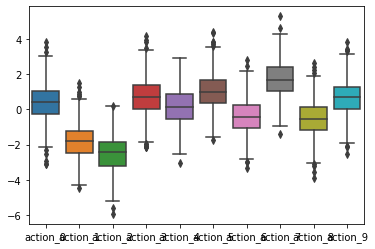

In [27]:
rd = RewardDistribution(k=10)
rd.plot()

Of course in reality you would not know this distribution. If you knew it, you probably would have been a millionaire by now. Even though we wouldn't know this universe encoded distribution we can use the strategic approach of epsilon greedy to model this distribution.   

## Epsilon bandit

In this model we will setup $k=10$ arm bandit for the system and compare four epsilon approaches (0.0, 0.01, 0.1, 0.5).

In [28]:
class EpsBandit:
    def __init__(self, rd, k, eps, iterations):
        self.k = k
        self.eps = eps
        self.total_avg_reward = 0.0
        self.qa = np.zeros(self.k)
        self.ac = np.zeros(self.k)
        self.iterations = iterations
        self.rd = rd

    def sample_an_action(self):

        def greedy_action():
            # pick action corresponding to high qa
            return np.argmax(self.qa)

        def random_action():
            # pick random action from k selections
            return np.random.choice(self.k)

        if self.eps == 0:
            # always greedy choice
            return greedy_action()
        else:
            p = np.random.rand()
            # high epsilon means more weight to random actions
            if p < self.eps:
                return random_action()
            else:
                return greedy_action()

    def execute_an_action(self, action):
        sampled_rewards = self.rd.get_reward(action=action)
        self.ac[action] += 1
        return sampled_rewards

    def log(self, t, action, r_t):
        print(f'==== step {t} ====')
        print(f'Sampled a reward {r_t} for action A_{action}')
        print(f'Tr {self.total_avg_reward}')
        print(f'qa {self.qa}')
        print(f'ac {self.ac}')
        print('\n')

    def get_total_average_rewards(self):
        return self.total_avg_reward
    
    def get_action_dist(self):
        return self.ac
    
    def run(self):
        avg_reward = [0.0]
        for t in range(1, self.iterations):
            action = self.sample_an_action()
            r_t = self.execute_an_action(action)
            self.total_avg_reward = running_average(m_n_1=self.total_avg_reward, r_i=r_t, n=t)
            self.qa[action] = running_average(m_n_1=self.qa[action], r_i=r_t, n=self.ac[action])
            avg_reward.append(float(self.total_avg_reward))
        return avg_reward

epsilon 0.0 means we always take greedy actions, actions which have maximum rewards in the past. epsilon 0.5 means, 50% of the time we can actions which have maximum rewards in the past and 50% time we will be taking random actions.

In [29]:
def run_experiment(k=5, iterations=1000):
    rd = RewardDistribution(k=k)
    #rd.plot()
    data = {}
    
    fmt = lambda i, eps, cnt: {'action': f"action_{i}", 'count': cnt, 'epsilon': f"eps_{eps}"}
    
    eps_0 = EpsBandit(rd=rd, k=k, eps=0.0, iterations=iterations)
    data['eps_0'] = eps_0.run()

    eps_0_0_1 = EpsBandit(rd=rd, k=k, eps=0.01, iterations=iterations)
    data['eps_0_0_1'] = eps_0_0_1.run()

    eps_0_1 = EpsBandit(rd=rd, k=k, eps=0.1, iterations=iterations)
    data['eps_0_1'] = eps_0_1.run()
    
    eps_0_5 = EpsBandit(rd=rd, k=k, eps=0.5, iterations=iterations)
    data['eps_0_5'] = eps_0_5.run()

    return pd.DataFrame(data)


Ok, now let's run this experiment.

In [30]:
df = run_experiment()

We just ran this experiment for a time step of 1000 and we the collected the running average rewards for different epsilon. As we repeat these experiments our <b>Q</b> values will converge to <b>Q*</b> values. 

## Running episodes

If you notice we sampled reward distribution one time <b>RewardDistribution</b> and we reused it for different epsilon experiment. We need to repeat this experiment many times with different reward distribution for our values to converge to optimal values.  

In [31]:
def run_episodes(episodes=1000):
    result = dict()
    iterations = 1000
    result['eps_0'] = np.zeros(iterations)
    result['eps_0_0_1'] = np.zeros(iterations)
    result['eps_0_1'] = np.zeros(iterations)
    result['eps_0_5'] = np.zeros(iterations)
    for episode in range(1, episodes):
        df = run_experiment(k=10, iterations=iterations)
        result['eps_0'] = running_average(m_n_1=result['eps_0'], r_i=np.asarray(df['eps_0']), n=episode)
        result['eps_0_0_1'] = running_average(m_n_1=result['eps_0_0_1'], r_i=np.asarray(df['eps_0_0_1']), n=episode)
        result['eps_0_1'] = running_average(m_n_1=result['eps_0_1'], r_i=np.asarray(df['eps_0_1']), n=episode)
        result['eps_0_5'] = running_average(m_n_1=result['eps_0_5'], r_i=np.asarray(df['eps_0_5']), n=episode)
        _df = pd.DataFrame(result)
    return _df

Now that we have the data we need, we shall format it and prepare for plotting.

In [32]:
def prepare_data_for_plotting(_df):
    entries = []
    for time_step in range(0, 1000):
        entries.append({'time_step': time_step, 'epsilon': 'eps_0', 'average_reward': _df['eps_0'][time_step]})
        entries.append({'time_step': time_step, 'epsilon': 'eps_0_0_1', 'average_reward': _df['eps_0_0_1'][time_step]})
        entries.append({'time_step': time_step, 'epsilon': 'eps_0_1', 'average_reward': _df['eps_0_1'][time_step]})
        entries.append({'time_step': time_step, 'epsilon': 'eps_0_5', 'average_reward': _df['eps_0_5'][time_step]})
    dframe = pd.DataFrame(entries)
    return dframe
    
_df = run_episodes(episodes=100)
dframe = prepare_data_for_plotting(_df)

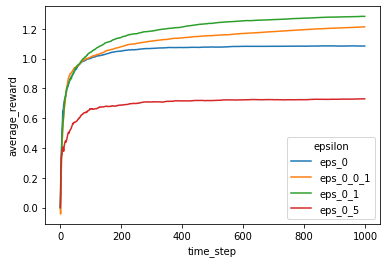

In [33]:
sns.lineplot(data=dframe, x='time_step', y='average_reward', hue='epsilon')

## Optimistic Initial Values in non stationary environments

In the literature we model these average estimates as <b>$Q$</b> values. Using a similar defination as above let <b>$R_i$</b> now denote reward received after the <b>$i^ith$</b> iteration for a given action. Let <b>$Q_n$</b> denote the estimate of its action value after it has been selected <b>$n-1$</b> times then

\begin{equation*}
Q_n = \frac{R_1+R_2+R_3+....+R_n-1}{n-1}
\end{equation*}

From the derivation made using running averages we can say

\begin{equation*}
Q_{n+1} = Q_n + \frac{1}{n}*(R_n-Q_n)
\end{equation*}

This can be informally viewed as this

<b>New Estimate</b> $\leftarrow$ <b>Old Estimate</b> + <b>Step Size</b> (<b>Target</b> - <b>Old Estimate</b>)

The methods discussed so far are dependent to some extent on the initial Q values, ie, $Q_1(a)$. In other words these methods are biases with initial values of $Q$. The bias will disappear when all actions are samples infinite time by the law of large numbers. On the other hand in the methods discusses so far we assumed that the enviornment is fixed with a sationary reward distribution. However we know that in real world reward distibution keep changing. So model this problem we need the agent must be encourage to explore more based on the enviorment dynamics. As number of iterations run towards infinity $\frac{1}{n}$ tends towards 0. Which means for large iterations we can model $\frac{1}{n}$ as a fraction close to 0. We shall represent this by alpha $\alpha$ where $\alpha \in (0, 1]$

\begin{equation*}
Q_{n+1} = Q_n + \alpha*(R_n-Q_n)
\end{equation*}

Since, the step-size parameter $\alpha$ is constant we can derive the following.

\begin{equation*}
Q_{n+1} = \alpha * R_n + (1-\alpha) * Q_{n}
\end{equation*}

\begin{equation*}
Q_{n+1} = \alpha * R_n + (1-\alpha) * (\alpha * R_{n-1}+(1-\alpha) * Q_{n-1})
\end{equation*}

\begin{equation*}
Q_{n+1} = \alpha * R_n + (1-\alpha) * \alpha * R_{n-1} + (1-\alpha)^{2} * Q_{n-1}
\end{equation*}

\begin{equation*}
Q_{n+1} = \alpha * R_n + (1-\alpha) * \alpha * R_{n-1} + (1-\alpha)^{2} * \alpha * R_{n-2} + ... + (1-\alpha)^{n-1}\alpha* R_{n-1}+(1-\alpha)^{n} * Q_{1}
\end{equation*}

\begin{equation*}
Q_{n+1} = (1-\alpha)^{n} * Q_{1} + \sum_{i=1}^n (1-\alpha)^{n-i}*R_{i}
\end{equation*}

Modeling $\frac{1}{n}$ as $\alpha$ indicate that the system will never converge but hover around the near optimal values and this can be a desirable property in a non stationary rewards enviroment.

## Upper confidence bound

In this model we will use same setup $k=10$ arm bandit for the system and compare four epsilon approaches (0.0, 0.01, 0.1) with upper confidence bound. e-greedy action selection forces the non-greedy actions to be tried, but indiscriminately, with no preferance for those of near greedy. We need to taken into account how close estimates are for other actions too. 

\begin{equation*}
A_t = argmax(Q_t(a)+c*\sqrt{\frac{ln(t)}{N_t(a)}})
\end{equation*}

$ln(t)$ denotes the natural logarithm of time steps and $N_t(a)$ represents number of times an action was chosen. In the above equation the square root term measures the uncertainity or variance in the estimates of action values. And $c$ represents the confidence in those estimates.

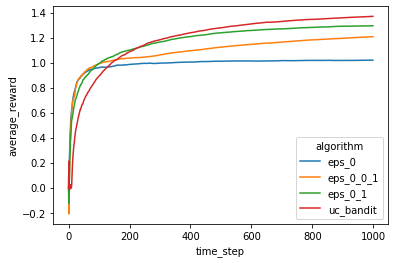

In [34]:
class UCBandit:
    def __init__(self, rd, k, iterations):
        self.k = k
        self.total_avg_reward = 0.0
        self.qa = np.zeros(self.k)
        self.ac = np.ones(self.k)
        self.iterations = iterations
        self.rd = rd
        self.c = 2
    
    def sample_an_action(self):
        uncertainity = np.log(self.iterations)/self.ac
        uc = self.c * np.sqrt(uncertainity)
        return np.argmax(self.qa+uc)

    def execute_an_action(self, action):
        sampled_rewards = self.rd.get_reward(action=action)
        self.ac[action] += 1
        return sampled_rewards

    def log(self, t, action, r_t):
        print(f'==== step {t} ====')
        print(f'Sampled a reward {r_t} for action A_{action}')
        print(f'Tr {self.total_avg_reward}')
        print(f'qa {self.qa}')
        print(f'ac {self.ac}')
        print('\n')

    def get_total_average_rewards(self):
        return self.total_avg_reward
    
    def get_action_dist(self):
        return self.ac
    
    def run(self):
        avg_reward = [0.0]
        for t in range(1, self.iterations):
            action = self.sample_an_action()
            r_t = self.execute_an_action(action)
            self.total_avg_reward = running_average(m_n_1=self.total_avg_reward, r_i=r_t, n=t)
            self.qa[action] = running_average(m_n_1=self.qa[action], r_i=r_t, n=self.ac[action])
            avg_reward.append(float(self.total_avg_reward))
            #self.log(t, action, r_t)
        return avg_reward
                         
def run_experiment(k=5, iterations=1000):
    rd = RewardDistribution(k=k)
    #rd.plot()
    data = {}
    
    fmt = lambda i, eps, cnt: {'action': f"action_{i}", 'count': cnt, 'epsilon': f"eps_{eps}"}
    
    eps_0 = EpsBandit(rd=rd, k=k, eps=0.0, iterations=iterations)
    data['eps_0'] = eps_0.run()

    eps_0_0_1 = EpsBandit(rd=rd, k=k, eps=0.01, iterations=iterations)
    data['eps_0_0_1'] = eps_0_0_1.run()

    eps_0_1 = EpsBandit(rd=rd, k=k, eps=0.1, iterations=iterations)
    data['eps_0_1'] = eps_0_1.run()
    
    uc_bandit = UCBandit(rd=rd, k=k, iterations=iterations)
    data['uc_bandit'] = uc_bandit.run()

    return pd.DataFrame(data)

df = run_experiment()

def run_episodes(episodes=1000):
    result = dict()
    iterations = 1000
    result['eps_0'] = np.zeros(iterations)
    result['eps_0_0_1'] = np.zeros(iterations)
    result['eps_0_1'] = np.zeros(iterations)
    result['uc_bandit'] = np.zeros(iterations)
    for episode in range(1, episodes):
        df = run_experiment(k=10, iterations=iterations)
        result['eps_0'] = running_average(m_n_1=result['eps_0'], r_i=np.asarray(df['eps_0']), n=episode)
        result['eps_0_0_1'] = running_average(m_n_1=result['eps_0_0_1'], r_i=np.asarray(df['eps_0_0_1']), n=episode)
        result['eps_0_1'] = running_average(m_n_1=result['eps_0_1'], r_i=np.asarray(df['eps_0_1']), n=episode)
        result['uc_bandit'] = running_average(m_n_1=result['uc_bandit'], r_i=np.asarray(df['uc_bandit']), n=episode)
        _df = pd.DataFrame(result)
    return _df

def prepare_data_for_plotting(_df):
    entries = []
    for time_step in range(0, 1000):
        entries.append({'time_step': time_step, 'algorithm': 'eps_0', 'average_reward': _df['eps_0'][time_step]})
        entries.append({'time_step': time_step, 'algorithm': 'eps_0_0_1', 'average_reward': _df['eps_0_0_1'][time_step]})
        entries.append({'time_step': time_step, 'algorithm': 'eps_0_1', 'average_reward': _df['eps_0_1'][time_step]})
        entries.append({'time_step': time_step, 'algorithm': 'uc_bandit', 'average_reward': _df['uc_bandit'][time_step]})
    dframe = pd.DataFrame(entries)
    return dframe
    
_df = run_episodes(episodes=100)
dframe = prepare_data_for_plotting(_df)

sns.lineplot(data=dframe, x='time_step', y='average_reward', hue='algorithm')

## Associative Search (Contextual Bandits)

Associated search involves both trial-and-error learning to search for the best actions and associations of these actions with the situations in which they are best. Associative search tasks are intermediate between the k-armed bandit and the reinforcement learning problem. The scope of study of these algorithms are beyond the scope of this article and I plan to cover them in upcoming articles.

## Conclusion

In these article we defined the problem of exploration/exploitation and its applications in real world. We also demonstrated that near greedy solutions are efficient in epsilon greedy settings. We also saw how upper confidence bound algorithms perform better than epsilon greedy algorithms but they are limited to stationary environments. We finally laid ground work to associative search or contextual bandits algorithms.